# 这是多面体硬颗粒的统计力学模拟程序
### First：载入库 载入粒子形状 载入原初样品（如果有）

In [1]:
import hcpmc
import os
factory = hcpmc.particlefactory.Family423(1.65,2.286)
factorystr = "hcpmc.initializer.particlefactory.Family423(1.65,2.286)"
init = hcpmc.initializer.Expander(factory, os.path.abspath('sample0.gsd'))

# 一、制作原初样品

计算机模拟也是要先制作样品再进行测量计算的。一个样品的参数通常由粒子数目，粒子位置，粒子形状，粒子朝向，样品密度，晶格形状等组成。

原初样品指的是样品的一个单胞，其中只包括一个或几个粒子，拥有粒子形状、粒子朝向、粒子位置、晶格形状等参数。不含体系密度参数。

粒子的所有参数和盒子的所有参数合起来通常也被称为构型（configuration）。

目前可以生成的样品类型：Densest（最密堆积）、SC（简单立方）、FCC（面心立方）、BCC（体心立方）、HCP（密排六方）等。

流体样品只需密度足够小。运行一段时间后，粒子会自发形成流体。

#### （一）：生成晶格。普通晶格可以很快由下面代码块生成。

In [8]:
import hcpmc
import os
import numpy as np

# TODO: set the factory and the initializer
factory = hcpmc.particlefactory.Family423(a=1, c=3)
temp = "sample0.gsd"
init = hcpmc.initializer.SC(factory, temp)

# NO NEED TO CHANGE THIS
init.create_sample0()

#### （二）：最密堆积晶格。最密堆积由于需要尝试压缩粒子，需要计算一定时间。并且使用下述不同管道。

##### 步骤1：设定粒子形状以及单胞中粒子个数，运行下面代码

In [2]:
# you may use this code for user-defined shape.
import coxeter
import rowan
import numpy as np
rhombic_dodecahedron = coxeter.families.CatalanFamily.get_shape("Rhombic Dodecahedron")

vertices = rhombic_dodecahedron.vertices

for i in range(len(vertices)):
    vertices[i] = rowan.rotate(
        rowan.from_axis_angle([0, 1, 0], np.arctan(0.56123102 / 0.39685026)),
        vertices[i],
    )

for i in range(len(vertices)):
    if vertices[i][2] < 0:
        vertices[i] = rowan.rotate(rowan.from_axis_angle([0, 0, 1], np.pi / 3), vertices[i])

In [3]:
# Densest using different pipeline
import hcpmc
import numpy as np

# TODO: set the factory and the initializer
factory = hcpmc.particlefactory.Anyshape(vertices)
particle_per_cell = 1
seeds = np.arange(70)
temp = os.path.abspath('sample0.gsd')

init = hcpmc.initializer.Densest(factory, particle_per_cell, temp, seeds)

/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:43: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


##### 步骤2：发送命令开始压缩体系，复制最后两行代码到终端中执行可以查看运行进程。

In [4]:
init.compress()

Output: 
Error: Querying scheduler...
Submitting cluster job 'Densest/461d6be01df036c8e80cdfb1e4f3410d/compress/d1e489ec5a651badb23714932cc7ca94':
 - Group: compress(461d6be01df036c8e80cdfb1e4f3410d)
Submitting cluster job 'Densest/10598cbdfa12d4d36b5a219cf0519529/compress/e5b4950aca94bc560e8fbd0607b7b998':
 - Group: compress(10598cbdfa12d4d36b5a219cf0519529)
Submitting cluster job 'Densest/7e40e632d1d4c3838894d41c804758c3/compress/89e6444033ea912dabf25346fc27141d':
 - Group: compress(7e40e632d1d4c3838894d41c804758c3)
Submitting cluster job 'Densest/50c4dcf295681b73a6d2175f1b946579/compress/8a4265726464805f5eea26e82481861a':
 - Group: compress(50c4dcf295681b73a6d2175f1b946579)
Submitting cluster job 'Densest/7f3ce74af8e40081bf849f0dbfe7a932/compress/a4d5deec7943bba2a64bb3e5d8b56126':
 - Group: compress(7f3ce74af8e40081bf849f0dbfe7a932)
Submitting cluster job 'Densest/bb60d2acede9e27c9dd517cdc76917ae/compress/26ff8ab795a6d032ce2240e34330b149':
 - Group: compress(bb60d2acede9e27c9dd517cd

##### 步骤3：等待全部进程运行结束，运行下面的代码找到最密晶格。

In [5]:
# NO NEED TO CHANGE THIS
init.analysis()
init.create_sample0()

get successfully. packing fraction : 0.9999349209000487 


#### （三）低密度压缩而来的样品。利用允许少许重叠的方式压缩体系高效得到从低密度压缩而来的高密度的样品。

这种方法或许更贴合真实体系（如利用重力场使胶体聚团结晶）。此方法由Amir Haji-Akbari, Michael Engel等提出。后端代码来自杨宇恒。

每一次都尝试将体系某个轴缩短到原来的 $1-0.002*\delta_d$ ，并平衡equili步数。设定多个随机数，以得到更好更密的样品。

参考文献：Haji-Akbari, A., Engel, M., Keys, A. et al. Disordered, quasicrystalline and crystalline phases of densely packed tetrahedra. Nature 462, 773–777 (2009). https://doi.org/10.1038/nature08641

In [ ]:
!rm -r Compress

In [ ]:
# 结束本次任务
%cd Compress
import os
open('cancel.sh', 'w')
for filename in os.listdir(os.getcwd()):
    if filename.startswith("slurm"):
        with open('cancel.sh', "a+") as f:
            f.write(f'scancel {filename[6:-4]}\n' )
!bash cancel.sh
os.remove('cancel.sh')
!rm slurm*
%cd ..

In [ ]:
# Compress Project
from flow import FlowProject
import os
import numpy as np
seeds = np.arange(10)
sample0 = "/sample0.gsd"
samplename = "/sample.gsd"
delta_ds = 10**(np.linspace(-1, -3, 50))
equili = 1e4
replication = [1,1,1]
class Compress(FlowProject):
    pass

project = Compress.init_project("Compress")

for seed in seeds:
        job = project.open_job({'delta_ds': delta_ds,'seed':seed}).init()
        with job:
            init.create_sample(0.5, replication, job.path + sample0)
path = os.getcwd()  # get the absolute path of the current working directory

In [ ]:
f = open(path + "/Compress/project.py", "w")  # open 'project.py' file
lines = [
    "from flow import FlowProject\n",
    "import os\n",
    "import sys\n",
    "import hoomd\n",
    "import coxeter\n",
    "sys.path.append(os.getcwd() + \"/..\")\n",
    "import hcpmc\n",
    f"sample0name = \"{sample0}\"\n"
    f"samplename = \"{samplename}\"\n"]
for code in factorystr:
    lines.append(code)
lines += [
    f"equili = int({equili})\n",
    "class Compress(FlowProject):\n",
    "    pass\n",
    "@Compress.label\n",
    "def compress_ed(job):\n",
    "    return \"packing_fraction\" in job.document\n",
    "@Compress.post(compress_ed)\n",
    "@Compress.operation(directives={'memory': '1g', 'walltime': 120})\n",
    "def compress(job):\n",
    "    with job:\n",
    "        sim = hoomd.Simulation(device=hoomd.device.CPU(), seed = job.sp.seed)\n",
    "        sim.create_state_from_gsd(job.path + sample0name)\n"
    "        mc = factory.get_integrator()\n",
    "        sim.operations.integrator = mc\n",
    "        sim.run(0)\n",
    "        logger = hoomd.logging.Logger()\n",
    "        logger.add(mc, quantities=[\"type_shapes\"])\n",
    "        for delta_d in job.sp.delta_ds:\n",
    "            C = hcpmc.configuration.compress.hpmc_compress(sim, mc)\n",
    "            C.box_compress(delta_d, equili)\n",
    "            pf = sim.state.N_particles / sim.state.box.volume\n", 
    "            hoomd.write.GSD.write(state=sim.state,filename=f'{pf:.4f}.gsd',logger=logger,mode=\"xb\")\n"
    "        job.doc[\"packing_fraction\"] = sim.state.N_particles / sim.state.box.volume\n",
    "        os.remove(job.path + sample0name)\n",
    "if __name__ == \"__main__\":\n",
    "    Compress().main()\n",
]
f.writelines(lines)
f.flush()
f.close()

In [ ]:
# NO NEED TO CHANGE THIS
%cd Compress
!python3 project.py submit -o compress
%cd ..
path = os.getcwd() + '/Compress'
print('cd '+path)
print('watch -n 1 python3 project.py status')

# 二、制作不同密度的样品，同时计算压强值

#### 生成project和job。对于流体和固体生成不同project。

### Fluid Pipeline

对于流体计算，工作流如下：设定一组目标压强。首先，将原初样品的密度设为 $0.001$（逼近理想气体），令体系随机化。其次，对每个样品进行常规的 $NPT$ 模拟一定步数，以压缩至设定的压强（密度）。最后，在 $NVT$ 系综里，采样压强值。

流体样品的密度需要从平衡态读取，而非初始指定。

工作流同时支持 $Widom$ 插入粒子法计算化学势。

In [67]:
!rm -r Fluid

In [39]:
# 结束本次任务
%cd Fluid
import os
open('cancel.sh', 'w')
for filename in os.listdir(os.getcwd()):
    if filename.startswith("slurm"):
        with open('cancel.sh', "a+") as f:
            f.write(f'scancel {filename[6:-4]}\n' )
!bash cancel.sh
os.remove('cancel.sh')
!rm slurm*
%cd ..

/home/jwang/HOOMD_HPMC/amazing_v2_test/Fluid
/home/jwang/HOOMD_HPMC/amazing_v2_test


In [68]:
# Fluid Project
from flow import FlowProject
import os
import numpy as np
betaPs = np.arange(0.01, 8, 0.5)
replication = [8, 8, 8]
fluidsample0 = "/sample0.gsd"
samplename = "/sample.gsd"
seeds = [12345]
equilibrum_steps = 1e6
sampling_steps = 1e6

class Fluid(FlowProject):
    pass

project = Fluid.init_project("Fluid")

for betaP in betaPs:
    for seed in seeds:
        job = project.open_job({'betaP': betaP,'seed':seed}).init()
        with job:
            init.create_sample(0.001, replication, job.path + fluidsample0)
path = os.getcwd()  # get the absolute path of the current working directory
f = open(path + "/Fluid/project.py", "w")  # open 'project.py' file

/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


In [69]:
lines = [
    "from flow import FlowProject\n",
    "import os\n",
    "import sys\n",
    "sys.path.append(os.getcwd() + \"/..\")\n",
    "import hcpmc\n",
    f"sample0name = \"{fluidsample0}\"\n"
    f"samplename = \"{samplename}\"\n",
    f"factory = {factorystr}\n"
    f"equilibrum_steps = int({equilibrum_steps})\n",
    f"sampling_steps = int({sampling_steps})\n",
    "class Fluid(FlowProject):\n",
    "    pass\n",
    "@Fluid.label\n",
    "def betaP_ed(job):\n",
    "    return \"Pressure\" in job.document\n",
    "@Fluid.post(betaP_ed)\n",
    "@Fluid.operation(directives={'memory': '1g', 'walltime': 24})\n",
    "def compute_betaP(job):\n",
    "    with job:\n",
    "        P = hcpmc.equilibrium.fluid.Pressure(job.path + samplename, job.path + sample0name, factory)\n",
    "        P.calculate(job.sp.betaP, equilibrum_steps, sampling_steps, job.sp.seed)\n",
    "        job.doc[\"Pressure\"] = P.get_pressure()\n",
    "        job.doc[\"packing_fraction\"] = P.packingfraction\n",
    "        os.remove(job.path + sample0name)\n",
    
    "@Fluid.label\n",
    "def mu_ed(job):\n",
    "    return \"mu\" in job.document\n",
    "@Fluid.post(mu_ed)\n",
    "@Fluid.operation(directives={'memory': '1g', 'walltime': 24})\n",
    "def compute_mu(job):\n",
    "    with job:\n",
    "        mu = hcpmc.equilibrium.fluid.ChemicalPotential(job.path + samplename, factory)\n",
    "        mu.calculate(equilibrum_steps, sampling_steps, job.sp.seed)\n",
    "        job.doc[\"mu\"] = mu.get_chemical_potential()\n",
    
    "if __name__ == \"__main__\":\n",
    "    Fluid().main()\n",
    ]

f.writelines(lines)
f.flush()

In [71]:
# NO NEED TO CHANGE THIS
%cd Fluid
!python3 project.py submit -o compute_betaP
%cd ..
path = os.getcwd() + '/Fluid'
print('cd '+path)
print('watch -n 1 python3 project.py status')

/home/jwang/HOOMD_HPMC/amazing_v2_test/Fluid
Querying scheduler...
/home/jwang/HOOMD_HPMC/amazing_v2_test
cd /home/jwang/HOOMD_HPMC/amazing_v2_test/Fluid
watch -n 1 python project.py status


### Solid Pipeline

对于固体计算，工作流如下：设定一组样品密度。首先，对每个密度，通过原初样品的按比例扩张成为可用样品。然后，对每个样品在$Isothermal-Isobaric$ 系综内平衡一定步数后采样。

In [72]:
# Solid Project
from flow import FlowProject
import os
import numpy as np
packing_fractions = np.arange(0.5, 0.7, 0.01)
replication = [8, 8, 8]
samplename = "/sample.gsd"
seeds = [12345]
equilibrum_steps = 1e4
sampling_steps = 1e4

class Solid(FlowProject):
    pass


project = Solid.init_project("Solid")

for pf in packing_fractions:
    for seed in seeds:
        job = project.open_job({'pf': pf,'seed':seed}).init()
        with job:
            init.create_sample(pf, replication, job.path + samplename)
path = os.getcwd()  # get the absolute path of the current working directory
f = open(path + "/Solid/project.py", "w")  # open 'project.py' file

/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


In [73]:
lines = [
    "from flow import FlowProject\n",
    "import numpy as np\n",
    "import os\n",
    "import sys\n",
    "sys.path.append(os.getcwd() + \"/..\")\n",
    "import hcpmc\n",
    f"samplename = \"{samplename}\"\n",
    f"factory = {factorystr}\n"
    f"equilibrum_steps = int({equilibrum_steps})\n",
    f"sampling_steps = int({sampling_steps})\n",
    "class Solid(FlowProject):\n",
    "    pass\n",
    "@Solid.label\n",
    "def betaP_ed(job):\n",
    "    return \"Pressure\" in job.document\n",
    "@Solid.post(betaP_ed)\n",
    "@Solid.operation(directives={'memory': '1g', 'walltime': 48})\n",
    "def compute_betaP(job):\n",
    "    with job:\n",
    "        P = hcpmc.equilibrium.solid.Pressure(job.path + samplename, factory)\n",
    "        P.calculate(equilibrum_steps, sampling_steps, job.sp.seed)\n",
    "        job.doc[\"Pressure\"] = P.get_pressure()\n",
    "        job.doc[\"packing_fraction\"] = P.packingfraction\n",
    

    "if __name__ == \"__main__\":\n",
    "    Solid().main()\n",
    ]

f.writelines(lines)
f.flush()

In [74]:
# NO NEED TO CHANGE THIS
%cd Solid
!python3 project.py submit -o compute_betaP
%cd ..
path = os.getcwd() + '/Solid'
print('cd '+path)
print('watch -n 1 python3 project.py status')

/home/jwang/HOOMD_HPMC/amazing_v2_test/Solid
Querying scheduler...
Submitting cluster job 'Solid/5c9ccbf1ed1515e87fe4864bc3e8afd0/compute_beta/357ed4b8a614e576928bec22b2f59d2c':
 - Group: compute_betaP(5c9ccbf1ed1515e87fe4864bc3e8afd0)
Submitting cluster job 'Solid/999b4b8dacd18af1e85116c35fbac4b8/compute_beta/bca6ab061177a1c353ce8599b4c49731':
 - Group: compute_betaP(999b4b8dacd18af1e85116c35fbac4b8)
Submitting cluster job 'Solid/2751ee70cb1dea81b9ff65606a42d7e8/compute_beta/2861a8edbcd494be13d38eef8c493605':
 - Group: compute_betaP(2751ee70cb1dea81b9ff65606a42d7e8)
Submitting cluster job 'Solid/d13fbe194fec61d2fd1b067c52fbbf34/compute_beta/e24035c0ce2a0a426d503047f12b072a':
 - Group: compute_betaP(d13fbe194fec61d2fd1b067c52fbbf34)
Submitting cluster job 'Solid/d4e9b2fc57426e6ff8a9f042f658e77f/compute_beta/6e152ecc661b82056724febccb2165b3':
 - Group: compute_betaP(d4e9b2fc57426e6ff8a9f042f658e77f)
Submitting cluster job 'Solid/baff2e6ea4508463bd8ca5edba720510/compute_beta/30672beae822

# 三、固体样品的自由能计算

### Frenkel-Ladd Pipeline

 $Frenkel-Ladd$ 方法是计算样品绝对自由能的一种方式。工作流如下：前提，由二完成样品的制作。首先，给定要计算的样品的密度区间，选出可用的样品。然后，对每个 job 样品又创建了自己的 FreeEnergy Project，并提交到计算集群。接着，等待所有 job 完成，最后汇总结果，得到样品的绝对自由能。

 这里实际上在 Solid Project 的特定 job 中，又创建了新的 FreeEnergy Project 。

In [6]:
import signac
from flow import FlowProject
import numpy as np
import subprocess
import sys
import shutil

compute_pf_mn = 0.6
compute_pf_mx = 0.65
samplename = '/sample.gsd'
FL_equilibrum_steps = 2e4
FL_sampling_steps = 3e4
seeds = [12345]

class FreeEnergy(FlowProject):
    pass


project = signac.get_project("Solid")
for job in project:
    if 'pf' not in job.sp:
        shutil.rmtree(job.path)

In [14]:
import signac
from flow import FlowProject
import numpy as np

path = os.getcwd()
compute_pf_mn = 0.6
compute_pf_mx = 0.65
samplename = '/sample.gsd'
FL_equilibrum_steps = 2e4
FL_sampling_steps = 3e4
seeds = [12345]

class FreeEnergy(FlowProject):
    pass


project = signac.get_project("Solid")
for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        proj = FreeEnergy.init_project(job.path +"/FreeEnergy")
        ks = 10 ** (np.linspace(5 * (job.sp.pf + 0.2) - 7, 5 * (job.sp.pf + 0.2), 30))
        for k in ks:
            for seed in seeds:
                sp = dict(k=k, seed=seed)
                proj.open_job(sp).init()
        f = open(job.path + "/FreeEnergy/project.py", "w")
        code_lines = [
            "from flow import FlowProject\n",
            "import sys\n",
            "import os\n",
            f'sys.path.append("{path}")\n',
            "import hcpmc\n",
            f'samplename = os.getcwd() + "/..{samplename}"\n',
            f"factory = {factorystr}\n",
            f"equilibrium_steps = int({FL_equilibrum_steps})\n",
            f"sampling_steps = int({FL_sampling_steps})\n",
            "class FreeEnergy(FlowProject):\n",
            "    pass\n",
            "@FreeEnergy.label\n",
            "def finish(job):\n",
            '    return "dF" in job.document\n',
            "@FreeEnergy.post(finish)\n",
            "@FreeEnergy.operation(directives={'memory': '1g', 'walltime': 24})\n",
            "def sample(job):\n",
            "    with job:\n",
            "        H = hcpmc.equilibrium.solid.Harmonic(samplename, factory, job.sp.k)\n",
            "        H.calculate(equilibrium_steps, sampling_steps, job.sp.seed)\n",
            '        job.doc["dF"] = H.dF\n',
            'if __name__ == "__main__":\n',
            "    FreeEnergy().main()\n",
        ]
        f.writelines(code_lines)
        f.flush()


/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/jwang/miniforge3/envs/hd5/lib/python3.13/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types pro

In [19]:
import signac
from flow import FlowProject
import numpy as np
import os

project = signac.get_project("Solid")
for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        lines = [
            "#!/bin/bash\n",
            "cd ",
            job.path,
            "/FreeEnergy\n",
            "python3 project.py submit -o sample",
        ]
        with open("submit.sh", "w") as f:
            f.writelines(lines)
        !bash submit.sh
os.remove("submit.sh")

submit.sh: line 2: cd: /home/jwang/HOOMD_HPMC/amazing_v2_test/Solid/workspace/5c9ccbf1ed1515e87fe4864bc3e8afd0/FreeEnergy: No such file or directory
python: can't open file '/home/jwang/HOOMD_HPMC/amazing_v2_test/project.py': [Errno 2] No such file or directory
Querying scheduler...
Submitting cluster job 'FreeEnergy/0dbb559ded7c545d20e729911d98d8be/sample/73626b9177a0168d5e38bf0e875d4297':
 - Group: sample(0dbb559ded7c545d20e729911d98d8be)
Submitting cluster job 'FreeEnergy/960c678c64a41c48ecc5e621efbfcaf1/sample/29732a62f4d94f102e5eac58173ea0e2':
 - Group: sample(960c678c64a41c48ecc5e621efbfcaf1)
Submitting cluster job 'FreeEnergy/154f50c5dccbebc615cbecacaa462bdb/sample/9d26f4013356a66f0e2c008f04467934':
 - Group: sample(154f50c5dccbebc615cbecacaa462bdb)
Submitting cluster job 'FreeEnergy/487b16836bd7e17f8b71646ac5581300/sample/c9303a53e08bf8fd0d4b00cfe33850f3':
 - Group: sample(487b16836bd7e17f8b71646ac5581300)
Submitting cluster job 'FreeEnergy/7e08cc855b849647acb47f02b5fd5b36/samp

/tmp/ipykernel_26794/3399651262.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(energy_temp,np.log(ks))


7.901416708421367 +/- 0.0
9.203026539290194 +/- 0.0
7.173469205507201 +/- 0.0
8.304958513962822 +/- 0.0
7.526416302279393 +/- 0.0
8.735366707370082 +/- 0.0


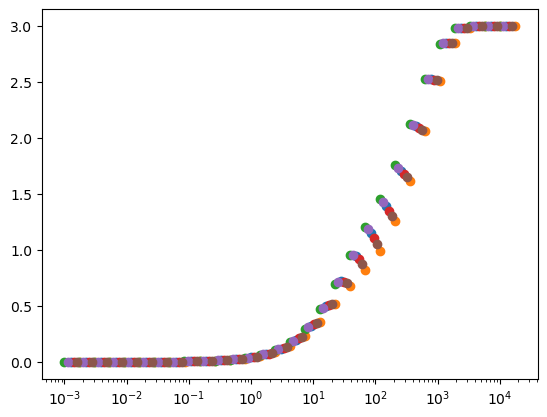

In [24]:
import signac
import gsd.hoomd
import matplotlib.pyplot as plt

project = signac.get_project("Solid")
for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        samplename = job.path+'/sample.gsd'
        Nsym = len(factory.get_symmetries())
        with gsd.hoomd.open(samplename, 'r') as f:
            N = f[0].particles.N
            box = f[0].configuration.box
            V = box[0] * box[1] * box[2]
            rho = N/V
        FE_project = signac.get_project(job.path+'/FreeEnergy')
        free_energy = []
        for seed in seeds: 
            energy_temp = dict()
            for subjob in FE_project:
                if subjob.sp.seed == seed:
                    try:
                        energy_temp[subjob.sp.k] = subjob.document['dF']
                    except:
                        print('Error in '+subjob.path)
            ks = np.array(sorted(energy_temp.keys()))
            energy_temp = np.array([energy_temp[k] for k in ks])
            plt.plot(ks,energy_temp,'o')
            plt.xscale('log')
            integral = np.trapz(energy_temp,np.log(ks))
            F_Ein = -3/2*(N-1)/N*np.log(np.pi/(ks[-1]/2))-3/2*np.log(np.pi/(ks[-1]/2))+np.log(2*np.pi**2)-np.log(Nsym)
            dF_CM = (-np.log(rho)+3/2*np.log(N))/N
            F_ig = np.log(rho)-1
            free_energy.append(F_Ein - integral - dF_CM)
        free_energy = np.array(free_energy)
        print(free_energy.mean(),'+/-',free_energy.std()/np.sqrt(len(free_energy)))
        job.doc['free_energy'] = f"{free_energy.mean()} +/- {free_energy.std()/np.sqrt(len(free_energy))}"

### Umbrella-Sampling Pipeline

 $Umbrella-Sampling$ 方法是计算样品非平衡态自由能的一种方式。工作流如下：前提，由二完成样品的制作。首先，给定要计算的样品的密度区间，选出要计算的样品。其次，给定反应坐标（或称选择序参量）。然后，对每个 job 样品又创建了自己的 Umbrella Project，并提交到计算集群。接着，等待所有 job 完成，最后汇总结果，得到样品的绝对自由能。

 这里实际上在 Solid Project 的特定 job 中，又创建了新的 Umbrella Project 。

In [41]:
import signac
from flow import FlowProject
import numpy as np

path = os.getcwd()
compute_pf_mn = 0.75
compute_pf_mx = 0.85
samplename = '/sample.gsd'
n_window = 30
ks = [8e6] * n_window
windows = np.linspace(1.5, 1.95, n_window)
seeds = [12345]
orderparameterstr = "hcpmc.OrderParameter.OrderParameterAveQlNear(4, 1.8, 12)"
sampling_steps = 5e4
simtrials = 50
equili_strict = 20

class Umbrella(FlowProject):
    pass


project = signac.get_project("Solid")

for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        proj = Umbrella.init_project(job.path +"/Umbrella")
        for k, window in zip(ks, windows):
            for seed in seeds:
                sp = dict(k=k, window=window, seed=seed)
                proj.open_job(sp).init()  # open a job with the specified statepoint
        
        f = open(job.path + "/Umbrella/project.py", "w")
        code_lines = [
            "from flow import FlowProject\n",
            "import sys\n",
            "import os\n",
            f'sys.path.append("{path}")\n',
            "import hcpmc\n",
            f'samplename = os.getcwd() + "/..{samplename}"\n',
            f"factory = {factorystr}\n",
            f"orderparameter = {orderparameterstr}\n"
            f"sampling_steps = int({sampling_steps})\n",
            f"simtrials = int({simtrials})\n",
            f"equili_strict = int({equili_strict})\n",
            
            "class Umbrella(FlowProject):\n",
            "    pass\n",
            "@Umbrella.label\n",
            "def finish(job):\n",
            '    return "done" in job.document\n',
            "@Umbrella.post(finish)\n",
            "@Umbrella.operation(directives={'memory': '1g', 'walltime': 15})\n",
            "def sample(job):\n",
            "    with job:\n",
            "        H = hcpmc.umbrella.UmbrellaSampling.BiasSampling(samplename,factory,job.sp.k,job.sp.window,sampling_steps)\n",
            "        H.calculate(orderparameter,simtrials,equili_strict,job.sp.seed)\n",
            '        job.doc["done"] = 1\n',
            'if __name__ == "__main__":\n',
            "    Umbrella().main()\n",
        ]
        f.writelines(code_lines)
        f.flush()


LookupError: Unable to determine project id for nonexistent path '/home/jwang/HOOMD_HPMC/amazing_v2_test/Solid'.

In [ ]:
import signac
from flow import FlowProject
import numpy as np
import os

project = signac.get_project("Solid")
for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        lines = [
            "#!/bin/bash\n",
            "cd ",
            job.path,
            "/Umbrella\n",
            "python3 project.py submit -o sample",
        ]
        with open("submit.sh", "w") as f:
            f.writelines(lines)
        !bash submit.sh
os.remove("submit.sh")

In [ ]:
import signac
import gsd.hoomd
import matplotlib.pyplot as plt

project = signac.get_project("Solid")
for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        proj = signac.get_project(job.path+'/Umbrella')
        timeseries_paths = []
        windows = []
        ks = []
        for subjob in proj:
            timeseries_paths.append(subjob.path+f'/window_{subjob.sp.window:.3f}.dat')
            windows.append(subjob.sp.window)
            ks.append(subjob.sp.k)
        with open(job.path+'/Umbrella/metadata.txt', 'w') as f:
            f.write('# timeseries list for wham\n')
            for path,window,k in zip(timeseries_paths,windows,ks):
                f.write(path+' '+str(window)+' '+str(k)+'\n')
        hist_left = min(windows) - (max(windows)-min(windows))/10
        hist_right = max(windows) + (max(windows)-min(windows))/10
        num_hist = 100
        tolerance = 1e-5
        temperature = 1
        metafilename = job.path+'/Umbrella/metadata.txt'
        outfilename = job.path + '/Umbrella/pmf.out'
        print(f'wham {hist_left} {hist_right} {num_hist} {tolerance} {temperature} 0 {metafilename} {outfilename}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import signac
from matplotlib.colors import Normalize
project = signac.get_project("Solid")
datas = dict()
plt.figure(figsize=(8, 5), dpi=150)  # 设置图像大小和分辨率
for job in project:
    if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
        data = np.loadtxt(job.path+"/Umbrella/pmf.out", comments="#")  # 跳过以 # 开头的注释行
        x = data[:, 0]  # 反应坐标（单位：Å）
        free_energy = data[:, 1]  # 自由能（单位：kcal/mol）
        datas[job.sp.pf] = [x,free_energy]
        
pfs = np.array(sorted(datas.keys()))
datas = np.array([datas[pf] for pf in pfs])
cmap = plt.get_cmap('plasma')
norm = Normalize(vmin=min(pfs), vmax=max(pfs))
colors = [cmap(norm(v)) for v in pfs]
for i in range(len(datas)):
    x = datas[i][0]
    free_energy = datas[i][1]
    plt.plot(
        x,
        free_energy/400,
        color=colors[i],
        linewidth=2,
        # marker="o",
        markersize=5,
        label=f"{pfs[i]:.2f}",
        alpha = 0.8
    )

    # if data.shape[1] >= 3:
    #     error = data[:, 2]  # 第2列是自由能误差
    #     plt.fill_between(
    #         x,
    #         free_energy - error,
    #         free_energy + error,
    #         alpha=0.3,
    #         color="skyblue",
    #         label="Error",
    #     )

    # 设置坐标轴
    plt.xlabel("Reaction Coordinate", fontsize=12)
    plt.ylabel(r"$F/(Nk_BT)$", fontsize=12)
    plt.title("Free Energy", fontsize=14)

    # plt.xlim(x.min() - 0.5, x.max() + 0.5)
    # plt.ylim(
    #     np.floor(-0.1),
    #     np.ceil(free_energy.max() + 1),
    # )

    # 添加辅助元素
    plt.grid(alpha=0.3, linestyle="--")  # 半透明虚线网格
    plt.legend(frameon=False)  # 无边框图例
    # plt.show()
    # # 保存图像（支持PDF/PNG/SVG等格式）
    # plt.savefig("pmf_plot.png", bbox_inches="tight", dpi=300)

### 任意样品的FL

In [ ]:
import signac
from flow import FlowProject
import numpy as np
import os
sample_dir = os.path.abspath('visualization')
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        lines = [
            "#!/bin/bash\n",
            "#SBATCH --job-name=equili\n",
            "#SBATCH --output=/dev/null\n"
            "#SBATCH --mem=1G\n",
            "#SBATCH --time=1:00:00\n"
            f"python3 equili.py {samplename}",
        ]
        with open("submit.sh", "w") as f:
            f.writelines(lines)
        !sbatch submit.sh
os.remove("submit.sh")

In [ ]:
import os
import shutil

# 定义当前目录和目标目录
current_dir = os.getcwd()+'/visualization'  # 当前文件夹
target_dir = os.path.join(current_dir, "origin_gsd")  # 目标文件夹

# 如果目标文件夹不存在，则创建
os.makedirs(target_dir, exist_ok=True)

# 遍历当前目录下的所有 .gsd 文件
for filename in os.listdir(current_dir):
    if filename.endswith(".gsd") and not filename.endswith("_FL.gsd"):
        src_path = os.path.join(current_dir, filename)  # 源文件路径
        dst_path = os.path.join(target_dir, filename)  # 目标路径
        shutil.move(src_path, dst_path)  # 移动文件
        # print(f"Moved: {filename} → {target_dir}/")

print("操作完成！")

In [ ]:
import signac
from flow import FlowProject
import numpy as np
import os

sample_dir = os.path.abspath('visualization')
path = os.getcwd()
FL_equilibrum_steps = 15e4
FL_sampling_steps = 5e4
seeds = [12345]
class FreeEnergy(FlowProject):
    pass
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        # project = signac.get_project("Solid")
        # for job in project:
        #     if job.sp.pf > compute_pf_mn - 1e-3 and job.sp.pf < compute_pf_mx + 1e-3:
                    projectdir = sample_dir + '/'+samplename[:-4]
                    proj = FreeEnergy.init_project(projectdir)
                    ks = 10 ** (np.linspace(0, 9, 24))
                    for k in ks:
                        for seed in seeds:
                            sp = dict(k=k, seed=seed)
                            proj.open_job(sp).init()
                    f = open(projectdir+"/project.py", "w")
                    code_lines = [
                        "from flow import FlowProject\n",
                        "import sys\n",
                        "import os\n",
                        "import hoomd\n",
                        f'sys.path.append("{path}")\n',
                        "import hcpmc\n",
                        f'samplename = "{sample_dir+'/'+samplename}"\n',
                        f"factory = {factorystr}\n",
                        f"equilibrium_steps = int({FL_equilibrum_steps})\n",
                        f"sampling_steps = int({FL_sampling_steps})\n",
                        "class FreeEnergy(FlowProject):\n",
                        "    pass\n",
                        "@FreeEnergy.label\n",
                        "def finish(job):\n",
                        '    return "dF" in job.document\n',
                        "@FreeEnergy.post(finish)\n",
                        "@FreeEnergy.operation(directives={'memory': '1g', 'walltime': 24})\n",
                        "def sample(job):\n",
                        "    with job:\n",
                        "       H = hcpmc.equilibrium.solid.Harmonic(samplename, factory, job.sp.k)\n",
                        "       H.calculate(equilibrium_steps, sampling_steps, job.sp.seed)\n",
                        '       job.doc["dF"] = H.dF\n',
                        'if __name__ == "__main__":\n',
                        "    FreeEnergy().main()\n",
                    ]
                    f.writelines(code_lines)
                    f.flush()


In [ ]:
import signac
from flow import FlowProject
import numpy as np
import os

for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        projectdir = sample_dir + '/'+samplename[:-4]
        lines = [
            "#!/bin/bash\n",
            "cd ",
            projectdir,
            "\n",
            "python3 project.py submit -o sample",
        ]
        with open("submit.sh", "w") as f:
            f.writelines(lines)
        !bash submit.sh
os.remove("submit.sh")

In [ ]:
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import pandas as pd
def norm(min,max,num):
    return (num-min)/(max-min)
class FreeEnergy(FlowProject):
    pass
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        projectdir = sample_dir + '/'+samplename[:-4]
        proj = FreeEnergy.init_project(projectdir)
        FE_project = signac.get_project(projectdir)
        for seed in seeds: 
            energy_temp = dict()
            for subjob in FE_project:
                if subjob.sp.seed == seed:
                    try:
                        df = pd.DataFrame(gsd.hoomd.read_log(subjob.path+"/Harmonic.gsd", scalar_only=True))
                        energy = df["log/hpmc/external/Harmonic/energy"]
                        plt.plot(energy)
                    except:
                        pass
        plt.title(f'Q4={samplename[:-7]}')
        plt.show()
        break

In [ ]:
import signac
import gsd.hoomd
import matplotlib.pyplot as plt

def norm(min,max,num):
    return (num-min)/(max-min)
class FreeEnergy(FlowProject):
    pass
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        projectdir = sample_dir + '/'+samplename[:-4]
        proj = FreeEnergy.init_project(projectdir)
        Nsym = len(factory.get_symmetries())
        with gsd.hoomd.open(sample_dir + '/'+samplename, 'r') as f:
            N = f[0].particles.N
            box = f[0].configuration.box
            V = box[0] * box[1] * box[2]
            rho = N/V
        
        FE_project = signac.get_project(projectdir)
        free_energy = []
        for seed in seeds: 
            energy_temp = dict()
            for subjob in FE_project:
                if subjob.sp.seed == seed:
                    try:
                        energy_temp[subjob.sp.k] = subjob.document['dF']
                    except:
                        print('Error in '+subjob.path)
            ks = np.array(sorted(energy_temp.keys()))
            energy_temp = np.array([energy_temp[k] for k in ks])
            # if abs(energy_temp[-1] - 3) < 0.01:
            plt.plot(ks,energy_temp,'o',label=samplename[:-4],color=plt.cm.plasma(norm(0.05,0.2,float(samplename[:-7]))))
            plt.xscale('log')
            integral = np.trapz(energy_temp,np.log(ks))
            F_Ein = -3/2*(N-1)/N*np.log(np.pi/(ks[-1]/2))-3/2*np.log(np.pi/(ks[-1]/2))+np.log(2*np.pi**2)-np.log(Nsym)
            dF_CM = (-np.log(rho)+3/2*np.log(N))/N
            F_ig = np.log(rho)-1
            free_energy.append(F_Ein - integral - dF_CM)
        free_energy = np.array(free_energy)
        # plt.legend()
        # plt.plot([ks[0],ks[-1]],[3,3],linestyle='--')
        # plt.show()
        # print(free_energy.mean(),'+/-',free_energy.std()/np.sqrt(len(free_energy)))
        with open(projectdir+'/FreeEnergy.txt','w') as f:
            f.write(f"{free_energy.mean()} +/- {free_energy.std()/np.sqrt(len(free_energy))}")
plt.plot([ks[0],ks[-1]],[3,3],linestyle='--')
# plt.legend()

In [ ]:
import hcpmc
import gsd.hoomd

FE = dict()
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        projectdir = sample_dir + '/'+samplename[:-4]
        data = open(projectdir+'/FreeEnergy.txt','r').read()
        sample = sample_dir+'/'+samplename
        realop = float(samplename[:-7])
        FE[realop] = float(data.split()[0])
        
ops = np.array(sorted(FE.keys()))
FE = np.array([FE[op] for op in ops])
# FE = FE - np.min(FE)
print(np.min(FE),ops[np.argmin(FE)])
plt.title('Frenkel')
plt.plot(ops,FE,marker='.',label="Frenkel-Ladd")
# plt.xlim(0.08,0.19)
# plt.ylim(17.779142342412058,17.779142342412058+7.1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import signac
import hcpmc
import gsd.hoomd

plt.figure(figsize=(8, 5), dpi=150)  # 设置图像大小和分辨率
FE = dict()
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        projectdir = sample_dir + '/'+samplename[:-4]
        data = open(projectdir+'/FreeEnergy.txt','r').read()
        sample = sample_dir+'/'+samplename
        realop = float(samplename[:-7])
        FE[realop] = float(data.split()[0])
        
ops = np.array(sorted(FE.keys()))
FE = np.array([FE[op] for op in ops])
# FE = FE - np.min(FE)
np.save('FL.npy',FE)
plt.xlim(0.08, 0.19)
plt.ylim(
    -0.1+np.min(FE),
    np.ceil(4)+np.min(FE),
)
plt.plot(
    ops,
    FE,
    linewidth=2,
    marker="o",
    markersize=5,
    label="frenkel",
)

# 设置坐标轴
plt.xlabel("Reaction Coordinate", fontsize=12)
plt.ylabel(r"$F/(Nk_BT)$", fontsize=12)
plt.title("Free Energy", fontsize=14)

# 添加辅助元素
plt.grid(alpha=0.3, linestyle="--")  # 半透明虚线网格
plt.legend(frameon=False)  # 无边框图例
plt.show()
# # 保存图像（支持PDF/PNG/SVG等格式）
# plt.savefig("pmf_plot.png", bbox_inches="tight", dpi=300)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import signac
import hcpmc
import gsd.hoomd

plt.figure(figsize=(8, 5), dpi=150)  # 设置图像大小和分辨率
FE = dict()
for samplename in os.listdir(sample_dir):
    if samplename.endswith('.gsd'):
        projectdir = sample_dir + '/'+samplename[:-4]
        data = open(projectdir+'/FreeEnergy.txt','r').read()
        sample = sample_dir+'/'+samplename
        realop = float(samplename[:-7])
        FE[realop] = float(data.split()[0])
        
ops = np.array(sorted(FE.keys()))
FE = np.array([FE[op] for op in ops])
FE = FE - np.min(FE)

plt.xlim(0.08, 0.19)
plt.ylim(
    -0.1,
    np.ceil(4),
)
plt.plot(
    ops,
    FE,
    linewidth=2,
    marker="o",
    markersize=5,
    label="frenkel",
)
data = np.loadtxt("pmf.out", comments="#")  # 跳过以 # 开头的注释行
x = data[:, 0]  # 反应坐标（单位：Å）
free_energy = data[:, 1]  # 自由能（单位：kcal/mol）

plt.plot(
    x,
    free_energy/64,
    linewidth=2,
    marker="o",
    markersize=5,
    label="umbrella",
)
# 设置坐标轴
plt.xlabel("Reaction Coordinate", fontsize=12)
plt.ylabel(r"$F/(Nk_BT)$", fontsize=12)
plt.title(r"$F432(1.65,2,2.286) \ BCCinit\ \phi=0.76$", fontsize=14)

# 添加辅助元素
plt.grid(alpha=0.3, linestyle="--")  # 半透明虚线网格
plt.legend(frameon=False)  # 无边框图例

# # 保存图像（支持PDF/PNG/SVG等格式）
plt.savefig("pmf_plot.png", bbox_inches="tight", dpi=300)

plt.show()

# 四、收菜


### 压强图

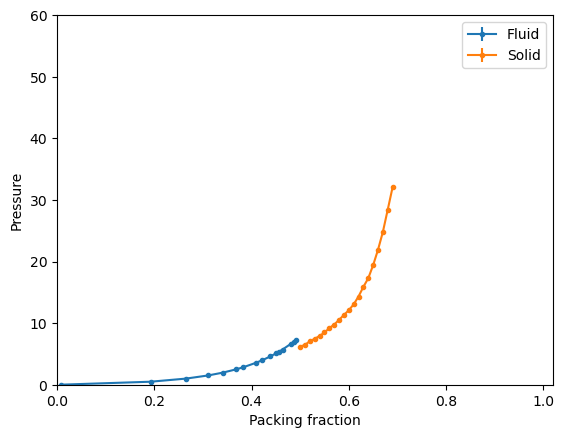

In [36]:
import signac
import matplotlib.pyplot as plt
import numpy as np

project = signac.get_project("Fluid")
fluid = dict()
fluid_err = dict()
for job in project:
    if "Pressure" in job.document:
        fluid[job.doc.packing_fraction] = float(job.doc["Pressure"].split()[0])
        fluid_err[job.doc.packing_fraction] = float(job.doc["Pressure"].split()[2])
pfs = np.array(sorted(fluid.keys()))
fluid = np.array([fluid[pf] for pf in pfs])
fluid_err = np.array([fluid_err[pf] for pf in pfs])
plt.errorbar(pfs,fluid,yerr=fluid_err,marker='.',label="Fluid")

project = signac.get_project("Solid")
solid = dict()
solid_err = dict()
for job in project:
    if "Pressure" in job.document:
        solid[job.sp.pf] = float(job.doc["Pressure"].split()[0])
        solid_err[job.sp.pf] = float(job.doc["Pressure"].split()[2])
pfs = np.array(sorted(solid.keys()))
solid = np.array([solid[pf] for pf in pfs])
solid_err = np.array([solid_err[pf] for pf in pfs])
plt.errorbar(pfs,solid,yerr=solid_err,marker='.',label="Solid")

plt.xlabel("Packing fraction")
plt.xlim(0,1.02)
plt.ylabel("Pressure")
plt.ylim(0,60)
plt.legend()
plt.savefig("Pressure.png")

### 可视化样品提取

In [28]:
import signac
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
project = signac.get_project("Solid")
data = os.getcwd() + '/Solid/visualization'
try:
    os.mkdir(data)
except:
    pass
for job in project:
    if "Pressure" in job.document:
        src = job.fn('equilibrium.gsd')
        dst = data + f'/{job.sp.pf:.3f}.gsd'
        shutil.copy(src, dst)
        print(f'{job.sp.pf:.3f} Done')

0.690 Done
0.620 Done
0.650 Done
0.660 Done
0.530 Done
0.680 Done
0.580 Done
0.500 Done
0.600 Done
0.630 Done
0.670 Done
0.610 Done
0.560 Done
0.640 Done
0.510 Done
0.520 Done
0.590 Done
0.570 Done
0.550 Done
0.540 Done


### 检测晶格畸变

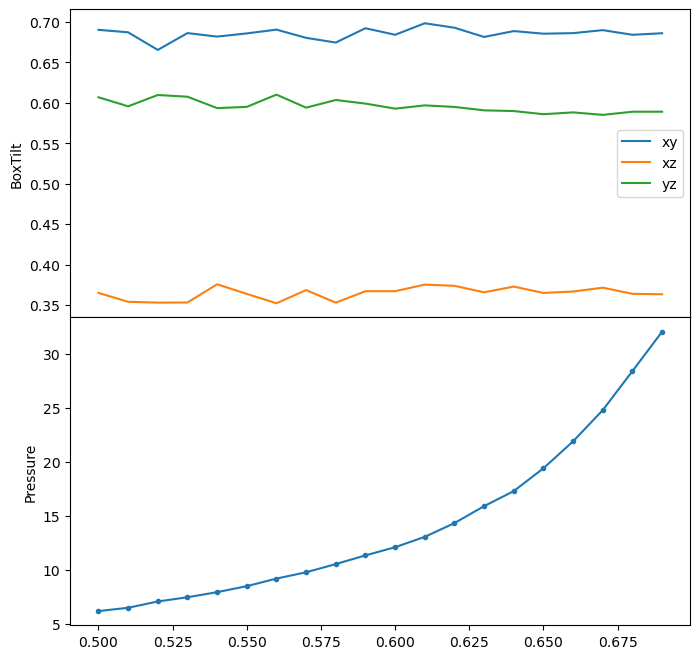

<Figure size 640x480 with 0 Axes>

In [37]:
import signac
import matplotlib.pyplot as plt
import numpy as np
import gsd.hoomd

# try:
project = signac.get_project("Solid")
box = dict()
box_err = dict()
solid = dict()
solid_err = dict()
for job in project:
    if "Pressure" in job.document:
        with gsd.hoomd.open(job.fn("equilibrium.gsd")) as f:
            temp = []
            for i in range(len(f) // 2):
                temp.append(f[-1 - i].configuration.box)
            box[job.sp.pf] = np.mean(temp, axis=0)
            box_err[job.sp.pf] = np.std(temp, axis=0)
        solid[job.sp.pf] = float(job.doc["Pressure"].split()[0])
        solid_err[job.sp.pf] = float(job.doc["Pressure"].split()[2])
pfs = np.array(sorted(solid.keys()))
solid = np.array([solid[pf] for pf in pfs])
solid_err = np.array([solid_err[pf] for pf in pfs])
box = np.array([box[pf] for pf in pfs])
box_err = np.array([box_err[pf] for pf in pfs])


# plt.figure()

# plt.plot([0.715,0.715],[0,60],color='black',linestyle="--")
# plt.ylim(7,9)
# plt.legend()

# 创建图形和第一个 y 轴
# 创建带分隔线的上下子图
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(8, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1], "hspace": 0},
    facecolor="white",
)

# 绘制第一组数据
# ax1.errorbar(pfs, box[:,3],box_err[:, 3], label="xy")
# ax1.errorbar(pfs, box[:,4],box_err[:, 4], label="xz")
# ax1.errorbar(pfs, box[:,5],box_err[:, 5], label="yz")
ax1.errorbar(
    pfs, box[:, 0] * pfs ** (1 / 3), box_err[:, 0] * pfs ** (1 / 3), label="Lx"
)
ax1.errorbar(
    pfs, box[:, 1] * pfs ** (1 / 3), box_err[:, 1] * pfs ** (1 / 3), label="Ly"
)
ax1.errorbar(
    pfs, box[:, 2] * pfs ** (1 / 3), box_err[:, 2] * pfs ** (1 / 3), label="Lz"
)
# ax1.plot([0.72,0.72],[-60,60],'--',color='black')
# ax1.plot([0.64,0.64],[-60,60],'--',color='black')
# ax1.set_ylim(-0.1 + 1e-6, 0.7)

ax1.set_xlabel("packing fraction")
ax1.set_ylabel("BoxTilt")
ax1.tick_params(axis="y")
ax1.legend()

ax2.errorbar(pfs, solid, yerr=solid_err, marker=".", label=r"$F432(1.65,2,2.285)$")
ax2.set_ylabel("Pressure")
# # 绘制第二组数据
# ax2.plot(pfs, box[:, 0] * pfs ** (1 / 3), label="Lx")
# ax2.plot(pfs, box[:, 1] * pfs ** (1 / 3), label="Ly")
# ax2.plot(pfs, box[:, 2] * pfs ** (1 / 3), label="Lz")
# # ax2.plot([0.72,0.72],[-60,60],'--',color='black')
# # ax2.plot([0.64,0.64],[-60,60],'--',color='black')
# # ax2.set_ylim(7.5, 15 - 1e-6)
# ax2.set_ylabel("BoxL")
# ax2.tick_params(axis="y")
# ax2.legend()

plt.show()
fig.savefig("box_tilt.png")

### 自由能图

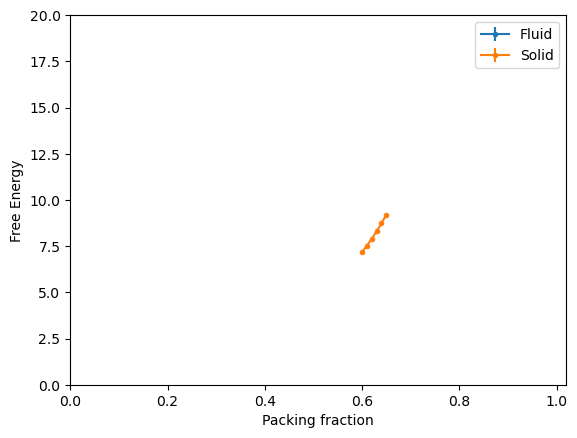

In [38]:
import signac
import matplotlib.pyplot as plt
import numpy as np

project = signac.get_project("Fluid")
fluid = dict()
fluid_err = dict()
for job in project:
    if "free_energy" in job.document:
        fluid[job.doc.packing_fraction] = float(job.doc["free_energy"].split()[0])
        fluid_err[job.doc.packing_fraction] = float(job.doc["free_energy"].split()[2])
pfs = np.array(sorted(fluid.keys()))
fluid = np.array([fluid[pf] for pf in pfs])
fluid_err = np.array([fluid_err[pf] for pf in pfs])
plt.errorbar(pfs,fluid,yerr=fluid_err,marker='.',label="Fluid")

project = signac.get_project("Solid")
solid = dict()
solid_err = dict()
for job in project:
    if "free_energy" in job.document:
        solid[job.sp.pf] = float(job.doc["free_energy"].split()[0])
        solid_err[job.sp.pf] = float(job.doc["free_energy"].split()[2])
pfs = np.array(sorted(solid.keys()))
solid = np.array([solid[pf] for pf in pfs])
solid_err = np.array([solid_err[pf] for pf in pfs])
plt.errorbar(pfs,solid,yerr=solid_err,marker='.',label="Solid")

plt.xlabel("Packing fraction")
plt.xlim(0,1.02)
plt.ylabel("Free Energy")
plt.ylim(0,20)
plt.legend()
plt.savefig("FreeEnergy.png")

### 打包所有数据(谨慎)

In [40]:
import os
import shutil
def ignore_exceptions_execute(code_lines):
    for line in code_lines:
        try:
            # 使用 exec 执行单行代码
            exec(line)
        except Exception as e:
            # 可以选择打印或记录异常信息
            print(f"Ignored exception in line '{line}': {str(e)}")
            continue
data_directory = os.getcwd() + "/s=0.4"
initstr = "Densest[F432(1.00,2,2.20)] : DSC"
with open("information.txt", "w") as f:
    f.write("--------------------------------\n\n")
    f.write(f"particle factory:{factorystr}\n\n")
    f.write(f"initialization:{initstr}\n\n")
    
code_lines = [
    "os.mkdir(data_directory)",
    "shutil.move('DensestProject', data_directory)",
    "shutil.move('information.txt', data_directory)",
    "shutil.move('Pressure.png', data_directory)",
    "shutil.move('box_tilt.png', data_directory)",
    "shutil.move('FreeEnergy.png', data_directory)",
    "shutil.move('Fluid', data_directory)",
    "shutil.move('Solid', data_directory)",
    "shutil.move('sample0.gsd', data_directory)"
]
ignore_exceptions_execute(code_lines)
print('Done!')

'/home/jwang/HOOMD_HPMC/amazing_v2_test/test1_2.286_in_BCC/sample0.gsd'